In [86]:
import requests
import json
import rasterio as rio
import rioxarray as rxr
import pandas as pd

from files import dsm_df
from files import dtm_df

import matplotlib.pyplot as plt
import earthpy.plot as ep
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


import plotly.graph_objects as go

import numpy as np


In [33]:
street='Steenplein'
number='1'
post='2000'

In [34]:
polygone=[]

In [35]:
def house_info(street, number, post):
    a=requests.get('https://api.basisregisters.dev-vlaanderen.be/v1/adressen?'+'straatnaam='+street+'&huisnummer='+number+'&postcode='+post+'&limit=1')
    b=a.json()
    id1= b['adressen'][0]['identificator']['objectId']
    print('Address found: Id1 is',id1)
    c=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden?adresObjectId='+id1)
    d=c.json()
    id2= d['gebouweenheden'][0]['identificator']['objectId']
    print('Building units found: Id2 is',id2)
    e=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/'+id2)
    f=e.json()
    id3= f['gebouw']['objectId']
    print('Building found: Id3 is',id3)
    g=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouwen/'+id3)
    h=g.json()
    poly=h['geometriePolygoon']['polygon']['coordinates'][0]
    polygone.append(poly)

In [36]:
house_info(street, number, post)

Address found: Id1 is 3118193
Building units found: Id2 is 16162446
Building found: Id3 is 16161095


In [89]:
x=polygone[0][0][0]
y=polygone[0][0][1]


In [38]:
file_dsm_selected = dsm_df.loc[
    (x < dsm_df.xmax) & (x > dsm_df.xmin) & (y < dsm_df.ymax) & (y > dsm_df.ymin)
]

dsm_selected = file_dsm_selected.index.format()[0]


In [39]:
file_dtm_selected = dtm_df.loc[
    (x < dtm_df.xmax) & (x > dtm_df.xmin) & (y < dtm_df.ymax) & (y > dtm_df.ymin)
]
dtm_selected = file_dtm_selected.index.format()[0]

In [40]:
geometries = [
    {
        'type': 'Polygon',
        'coordinates': polygone
    }
]

In [41]:
dsm_selected

'DHMVIIDSMRAS1m_k15.tif'

In [74]:
read_dsm = rxr.open_rasterio("DSM/" + dsm_selected).rio.clip(geometries, from_disk=True)
read_dtm = rxr.open_rasterio("DTM/" + dtm_selected).rio.clip(geometries, from_disk=True)

In [75]:
canopy =  read_dsm - read_dtm

In [76]:
canopy.rio.to_raster("clipped.tif")

In [77]:
with rio.open("clipped.tif") as img:
    chm = img.read(1)

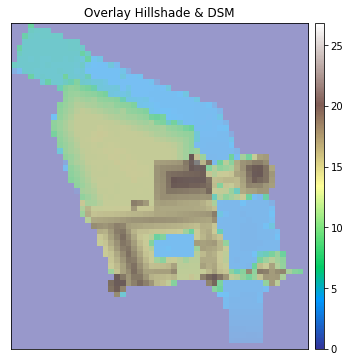

In [78]:
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    chm, ax=ax, cmap="terrain", title="Overlay Hillshade & DSM",
)
ax.imshow(chm, cmap="Greys", alpha=0.5)
plt.show()


In [85]:

z = chm
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='House', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [90]:
print('Altitude:',np.amax(z),'m')
print('Coordinates:',x,',',y)

Altitude: 26.846886 m
Coordinates: 152013.36398064345 , 212540.82101351395
